In [23]:
import pandas as pd
from functools import reduce
import numpy as np
from scipy.stats.stats import pearsonr
from scipy.stats import probplot
import pylab

## Import der Gemeindedaten

In [24]:
#Ausländeranteil
df_aus = pd.read_csv('Sozio-Daten/ausländeranteil.csv', encoding='latin', delimiter=';')

#Sozialhilfequote
df_soz = pd.read_csv('Sozio-Daten/sozialhilfequote.csv', encoding='latin', delimiter=';')

#SVP-Stimmen
df_svp = pd.read_csv('Sozio-Daten/svp-anteil.csv', encoding='latin', delimiter=';')

#Haushaltsgrösse
df_haushalt = pd.read_csv('Sozio-Daten/haushaltsgroesse.csv', encoding='latin', delimiter=';')

#Einkommen
df_einkommen = pd.read_csv('Sozio-Daten/einkommen.csv', encoding='latin', delimiter=';')

#Corona-Daten
df_corona = pd.read_csv('Exporte/fälle_pro_hundert.csv')

Die Datensets zu Ausländeranteil, Sozialhilfequote und Einkommen kommen aus der gleichen Quelle. Mit einer Funktion werden erste Formatierungen vorgenommen.

In [25]:
dataframes = [df_aus, df_soz, df_einkommen]

In [26]:
def df_handler(df_temp):
    df_temp['DATUM'] = pd.to_datetime(df_temp['DATUM'])
    df_temp.rename(columns={'BFSNR': 'bfs_nummer'}, inplace=True)
    return df_temp

In [27]:
for df in dataframes:
    df_handler(df)

## Individuelle Formatierungen und Berechnungen

**Ausländeranteil**

In [28]:
df_aus = df_aus[df_aus['DATUM'].dt.year == 2020]
df_aus['ausländeranteil'] = ((df_aus['AUSL_TOTAL'] / df_aus['TOTAL']) * 100).round(1)
df_aus = df_aus[['bfs_nummer', 'NAME', 'ausländeranteil']].copy()

<ipython-input-28-9b6b0c7e642b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aus['ausländeranteil'] = ((df_aus['AUSL_TOTAL'] / df_aus['TOTAL']) * 100).round(1)


**Sozialhilfequote**

In [29]:
df_soz = df_soz[df_soz['DATUM'].dt.year == 2019]
df_soz = df_soz[['bfs_nummer', 'SH_QUOTE']].copy()
df_soz.loc[df_soz['SH_QUOTE'] == 'X', 'SH_QUOTE'] = np.nan
df_soz['SH_QUOTE'] = df_soz['SH_QUOTE'].astype(float)

**SVP-Stimmen**

In [31]:
df_svp.rename(columns={'gemeinde_nummer': 'bfs_nummer'}, inplace=True)
df_svp = df_svp[(df_svp['bfs_nummer'] >= 4001) & (df_svp['bfs_nummer'] <= 4323)].copy()

In [32]:
df_svp = df_svp[['bfs_nummer', 'partei_bezeichnung_de', 'partei_staerke']].copy()

In [33]:
df_svp = df_svp.pivot_table(index=['bfs_nummer'], columns='partei_bezeichnung_de', values='partei_staerke')
df_svp.reset_index(inplace=True)
df_svp = df_svp[['bfs_nummer', 'SVP']].copy()

**Haushaltsgrösse**

In [34]:
df_haushalt.columns = ['gemeinde', 'haushalt', 'summe']
df_haushalt['bfs_nummer'] = df_haushalt['gemeinde'].str.split(' ').str[0].str.replace('......', '')
df_haushalt['bfs_nummer'] = df_haushalt['bfs_nummer'].astype(int)
df_haushalt = df_haushalt[(df_haushalt['bfs_nummer'] >= 4001) & (df_haushalt['bfs_nummer'] <= 4323)].copy()

In [35]:
df_haushalt = df_haushalt.pivot_table(index='bfs_nummer', columns='haushalt', values='summe')
df_haushalt.reset_index(inplace=True)
df_haushalt['anteil_haushalte_6+'] = ((df_haushalt['6 oder mehr Personen'] / df_haushalt['Haushaltsgrösse - Total']) * 100).round(1)
df_haushalt = df_haushalt[['bfs_nummer', 'anteil_haushalte_6+']].copy()

**Medianeinkommen**

In [36]:
df_einkommen = df_einkommen[df_einkommen['DATUM'].dt.year == 2017].copy()

In [37]:
df_einkommen = df_einkommen[['bfs_nummer', 'EK_REIN_MEDIAN']].copy()
df_einkommen.rename(columns={'EK_REIN_MEDIAN': 'Medianeinkommen'}, inplace=True)

In [38]:
df_einkommen['Medianeinkommen'] = df_einkommen['Medianeinkommen'].astype(float)

**Corona-Daten**

In [39]:
df_corona.rename(columns={'BFS-Nummer': 'bfs_nummer'}, inplace=True)
df_corona = df_corona[['bfs_nummer', 'fälle_pro_hundert', 'einwohner']].copy()

## Merge

In [40]:
final_frames = [df_aus, df_soz, df_svp, df_haushalt, df_einkommen, df_corona]
df = reduce(lambda left,right: pd.merge(left,right,on=['bfs_nummer'],
                                            how='outer'), final_frames)

In [41]:
df.sort_values(by='bfs_nummer', inplace=True)

#Nur Aargauuer Gemeinden
df = df[(df['bfs_nummer'] >= 4001) & (df['bfs_nummer'] <= 4323)].copy()

#Nur Gemeinden, wo der Name vorhanden ist (kein Name = fusionierte Gemeinde)
df = df[df['NAME'].notnull()].copy()

df.set_index('bfs_nummer', inplace=True)
df.columns = ['Gemeinde', 'Ausländeranteil', 'Sozialhilfequote', 'SVP-Wähleranteil', 'Anteil Haushalte 6+', 'Medianeinkommen', 'fälle_pro_hundert', 'einwohner']

## Korrelationsanalyse

In [44]:
#Nur Gemeinden mit mehr als 5000 Einwohnern
df = df[df['einwohner'] >= 5000].copy()

In [46]:
#Es müssen nun 35 Gemeinden sein
len(df)

35

In [47]:
#Sind alle Daten vorhanden?
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 4001 to 4289
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gemeinde             35 non-null     object 
 1   Ausländeranteil      35 non-null     float64
 2   Sozialhilfequote     35 non-null     float64
 3   SVP-Wähleranteil     35 non-null     float64
 4   Anteil Haushalte 6+  35 non-null     float64
 5   Medianeinkommen      35 non-null     float64
 6   fälle_pro_hundert    35 non-null     float64
 7   einwohner            35 non-null     float64
dtypes: float64(7), object(1)
memory usage: 2.5+ KB


**Spalten auf Normalverteilung prüfen**

Fazit: Die Normalverteilung wird für alle Indikatoren als gegeben erachtet.

((array([-2.06188401, -1.66883254, -1.4335397 , -1.25837339, -1.11509471,
         -0.99166098, -0.8817426 , -0.78156696, -0.68868392, -0.60139747,
         -0.51847288, -0.4389725 , -0.36215721, -0.28742406, -0.21426459,
         -0.14223572, -0.07093824,  0.        ,  0.07093824,  0.14223572,
          0.21426459,  0.28742406,  0.36215721,  0.4389725 ,  0.51847288,
          0.60139747,  0.68868392,  0.78156696,  0.8817426 ,  0.99166098,
          1.11509471,  1.25837339,  1.4335397 ,  1.66883254,  2.06188401]),
  array([5.12044228, 5.28157811, 5.60080611, 5.7465813 , 5.93952484,
         5.99406528, 6.28453039, 6.31919393, 6.36755666, 6.57451923,
         6.65938865, 6.74337581, 6.79944703, 6.91231473, 6.97632387,
         7.09477897, 7.13642638, 7.17850288, 7.2965642 , 7.3144302 ,
         7.3927279 , 7.40740741, 7.44653104, 7.4842494 , 7.50226655,
         7.55235478, 7.82593123, 8.01558258, 8.0444001 , 8.12790534,
         8.21917808, 8.66614751, 8.69463323, 9.78923102, 9.9001070

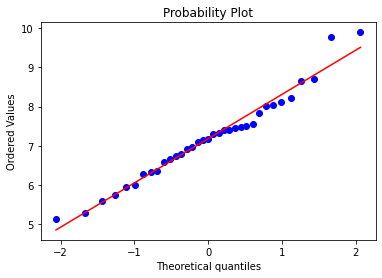

In [48]:
probplot(df['fälle_pro_hundert'].to_numpy(), dist="norm", plot=pylab)

((array([-2.06188401, -1.66883254, -1.4335397 , -1.25837339, -1.11509471,
         -0.99166098, -0.8817426 , -0.78156696, -0.68868392, -0.60139747,
         -0.51847288, -0.4389725 , -0.36215721, -0.28742406, -0.21426459,
         -0.14223572, -0.07093824,  0.        ,  0.07093824,  0.14223572,
          0.21426459,  0.28742406,  0.36215721,  0.4389725 ,  0.51847288,
          0.60139747,  0.68868392,  0.78156696,  0.8817426 ,  0.99166098,
          1.11509471,  1.25837339,  1.4335397 ,  1.66883254,  2.06188401]),
  array([15.9, 18.6, 19.7, 21.1, 21.4, 21.8, 22.1, 22.2, 23.1, 24.8, 25.1,
         25.7, 26. , 26.2, 26.7, 28.3, 28.7, 28.7, 28.8, 28.9, 29.2, 31.3,
         32.9, 32.9, 33. , 33.6, 34.2, 35.2, 37.7, 38.8, 39.7, 41.8, 44.4,
         49.5, 50.4])),
 (8.509222959948005, 29.954285714285717, 0.9775241051209521))

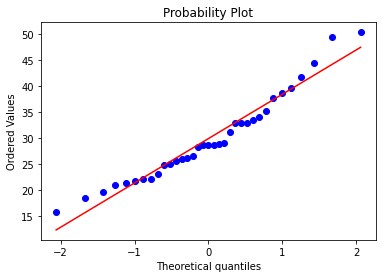

In [49]:
probplot(df['Ausländeranteil'].to_numpy(), dist="norm", plot=pylab)

((array([-2.06188401, -1.66883254, -1.4335397 , -1.25837339, -1.11509471,
         -0.99166098, -0.8817426 , -0.78156696, -0.68868392, -0.60139747,
         -0.51847288, -0.4389725 , -0.36215721, -0.28742406, -0.21426459,
         -0.14223572, -0.07093824,  0.        ,  0.07093824,  0.14223572,
          0.21426459,  0.28742406,  0.36215721,  0.4389725 ,  0.51847288,
          0.60139747,  0.68868392,  0.78156696,  0.8817426 ,  0.99166098,
          1.11509471,  1.25837339,  1.4335397 ,  1.66883254,  2.06188401]),
  array([1.2, 1.5, 1.6, 1.6, 1.6, 1.6, 1.9, 1.9, 2. , 2.1, 2.1, 2.2, 2.3,
         2.3, 2.3, 2.6, 2.6, 2.7, 2.7, 2.8, 2.8, 2.9, 3. , 3.2, 3.6, 3.6,
         3.6, 3.6, 3.7, 3.9, 3.9, 4.1, 4.6, 4.9, 5. ])),
 (1.0239865063460236, 2.8, 0.980262870596217))

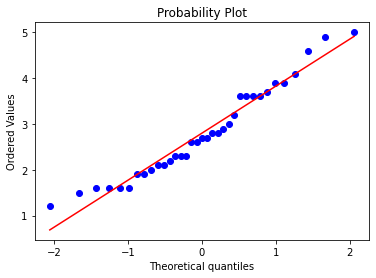

In [50]:
probplot(df['Sozialhilfequote'].to_numpy(), dist="norm", plot=pylab)

((array([-2.06188401, -1.66883254, -1.4335397 , -1.25837339, -1.11509471,
         -0.99166098, -0.8817426 , -0.78156696, -0.68868392, -0.60139747,
         -0.51847288, -0.4389725 , -0.36215721, -0.28742406, -0.21426459,
         -0.14223572, -0.07093824,  0.        ,  0.07093824,  0.14223572,
          0.21426459,  0.28742406,  0.36215721,  0.4389725 ,  0.51847288,
          0.60139747,  0.68868392,  0.78156696,  0.8817426 ,  0.99166098,
          1.11509471,  1.25837339,  1.4335397 ,  1.66883254,  2.06188401]),
  array([14.73451722, 16.34767692, 17.63818203, 18.02151707, 19.28173441,
         20.96538462, 22.27120625, 22.36690766, 22.59463722, 22.86483675,
         23.40886545, 26.61745742, 26.70099463, 26.81067344, 27.15310259,
         27.80619336, 28.83213914, 29.16414032, 30.4189198 , 30.52667616,
         31.07758007, 31.89916708, 31.91846603, 32.04652562, 32.10417611,
         33.52871287, 34.2867918 , 34.5221225 , 34.90252241, 35.26993112,
         35.86511048, 41.37154082, 4

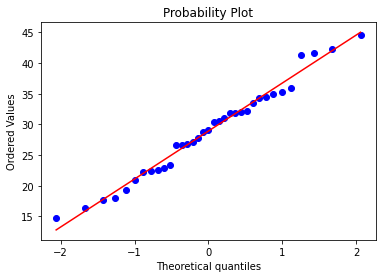

In [51]:
probplot(df['SVP-Wähleranteil'].to_numpy(), dist="norm", plot=pylab)

((array([-2.06188401, -1.66883254, -1.4335397 , -1.25837339, -1.11509471,
         -0.99166098, -0.8817426 , -0.78156696, -0.68868392, -0.60139747,
         -0.51847288, -0.4389725 , -0.36215721, -0.28742406, -0.21426459,
         -0.14223572, -0.07093824,  0.        ,  0.07093824,  0.14223572,
          0.21426459,  0.28742406,  0.36215721,  0.4389725 ,  0.51847288,
          0.60139747,  0.68868392,  0.78156696,  0.8817426 ,  0.99166098,
          1.11509471,  1.25837339,  1.4335397 ,  1.66883254,  2.06188401]),
  array([0.8, 0.9, 0.9, 1. , 1. , 1.1, 1.3, 1.3, 1.3, 1.4, 1.4, 1.4, 1.5,
         1.5, 1.5, 1.5, 1.6, 1.6, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.8, 1.8,
         1.8, 1.9, 1.9, 1.9, 2. , 2.2, 2.2, 2.8, 3. ])),
 (0.4762736087171767, 1.6142857142857143, 0.9643688079979241))

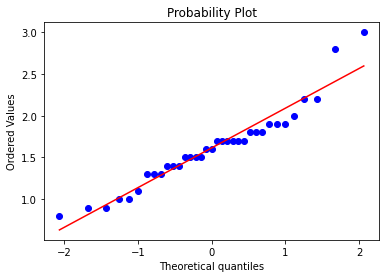

In [52]:
probplot(df['Anteil Haushalte 6+'].to_numpy(), dist="norm", plot=pylab)

((array([-2.06188401, -1.66883254, -1.4335397 , -1.25837339, -1.11509471,
         -0.99166098, -0.8817426 , -0.78156696, -0.68868392, -0.60139747,
         -0.51847288, -0.4389725 , -0.36215721, -0.28742406, -0.21426459,
         -0.14223572, -0.07093824,  0.        ,  0.07093824,  0.14223572,
          0.21426459,  0.28742406,  0.36215721,  0.4389725 ,  0.51847288,
          0.60139747,  0.68868392,  0.78156696,  0.8817426 ,  0.99166098,
          1.11509471,  1.25837339,  1.4335397 ,  1.66883254,  2.06188401]),
  array([46800., 47500., 48800., 50500., 50500., 50700., 52200., 52200.,
         52700., 52700., 53200., 53600., 53600., 53600., 54300., 54400.,
         54500., 54800., 54900., 55300., 55800., 55800., 56500., 56700.,
         56800., 56800., 56900., 57400., 58700., 59100., 59300., 59300.,
         60400., 62400., 66300.])),
 (4141.108439923074, 55000.0, 0.9869310429430286))

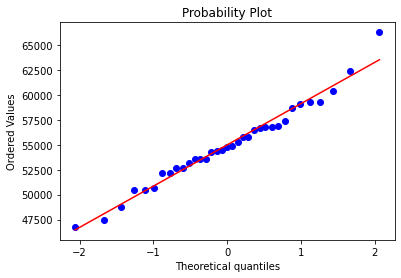

In [53]:
probplot(df['Medianeinkommen'].to_numpy(), dist="norm", plot=pylab)

**Korrelationskoeffizient und P-Wert berechnen**

- Die Corona-Fallzahl (abhängige Variable) hängt von den diversen Indikatoren (unabhängige Variable) ab.
- Interpretation der Korrelationsstärke nach Cohen: https://www.methodenberatung.uzh.ch/de/datenanalyse_spss/zusammenhaenge/korrelation.html
- Angenommenes Signifikanzniveau < 0,05

Die nachfolgend verwendete Funktion pearsonr gibt zunächst die Korrelation (r) aus und als zweiten Wert den P-Wert: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

Ausländeranteil: Starke Korrelation, statistisch signifikant

In [54]:
df[['fälle_pro_hundert', 'Ausländeranteil']].corr().round(3)
pearsonr(df['fälle_pro_hundert'], df['Ausländeranteil'])

(0.5466968940874362, 0.0006787807604775313)

Sozialhilfequote: Schwache Korrelation, statistisch nicht signifikant

In [55]:
df[['fälle_pro_hundert', 'Sozialhilfequote']].corr().round(3)
pearsonr(df['fälle_pro_hundert'], df['Sozialhilfequote'])

(0.22158655516685027, 0.20079578890054314)

SVP-Wähleranteil: Schwache Korrelation, statistisch nicht signifikant

In [56]:
df[['fälle_pro_hundert', 'SVP-Wähleranteil']].corr().round(3)
pearsonr(df['fälle_pro_hundert'], df['SVP-Wähleranteil'])

(0.23155094203847076, 0.18076710585711406)

Anteil grosser Haushalte: Schwache Korrelation, statistisch nicht signifikant

In [57]:
df[['fälle_pro_hundert', 'Anteil Haushalte 6+']].corr().round(3)
pearsonr(df['fälle_pro_hundert'], df['Anteil Haushalte 6+'])

(0.28536857584114705, 0.09657156380932375)

Medianeinkommen: Moderate Korrelation, statistisch signifikant

In [58]:
df[['fälle_pro_hundert', 'Medianeinkommen']].corr().round(3)
pearsonr(df['fälle_pro_hundert'], df['Medianeinkommen'])

(-0.4157268839203814, 0.013001569576966404)

**Kontrolle: Gibt es Zusammenhänge zwischen Ausländeranteil und Sozialhilfequote, Grosshaushalte, Medianeinkommen?**

Mittlere bis starke Korrelationen, darum: ja

In [77]:
#Ausländer vs. Sozialhilfe
pearsonr(df['Ausländeranteil'], df['Sozialhilfequote'])

(0.47848457207666195, 0.0036428694475507035)

In [78]:
#Ausländer vs. Grosshaushalte
pearsonr(df['Ausländeranteil'], df['Anteil Haushalte 6+'])

(0.6142033033588364, 8.683918644080617e-05)

In [79]:
#Ausländer vs. Medianeinkommen
pearsonr(df['Ausländeranteil'], df['Medianeinkommen'])

(-0.6411270917838496, 3.330373913215798e-05)

**Export für Scatterplots**

Vergleich Covid-Inzidenz mit den anderen Variablen

In [59]:
df[['Gemeinde', 'fälle_pro_hundert', 'Ausländeranteil']].to_csv('Sozio-Ergebnisse/ausländer.csv')
df[['Gemeinde', 'fälle_pro_hundert', 'Sozialhilfequote']].to_csv('Sozio-Ergebnisse/sozialhilfe.csv')
df[['Gemeinde', 'fälle_pro_hundert', 'SVP-Wähleranteil']].to_csv('Sozio-Ergebnisse/svp.csv')
df[['Gemeinde', 'fälle_pro_hundert', 'Anteil Haushalte 6+']].to_csv('Sozio-Ergebnisse/haushalte.csv')
df[['Gemeinde', 'fälle_pro_hundert', 'Medianeinkommen']].to_csv('Sozio-Ergebnisse/einkommen.csv')

Vergleich Ausländeranteil mit den anderen Variablen

In [75]:
df[['Gemeinde', 'Ausländeranteil', 'Sozialhilfequote']].to_csv('Sozio-Ergebnisse/ausländer_soz.csv')
df[['Gemeinde', 'Ausländeranteil', 'Anteil Haushalte 6+']].to_csv('Sozio-Ergebnisse/ausländer_haushalt.csv')
df[['Gemeinde', 'Ausländeranteil', 'Medianeinkommen']].to_csv('Sozio-Ergebnisse/ausländer_einkommen.csv')
df[['Gemeinde', 'Ausländeranteil', 'SVP-Wähleranteil']].to_csv('Sozio-Ergebnisse/ausländer_svp.csv')

In [85]:
df.to_csv('Sozio-Ergebnisse/alle_daten.csv')

## Einteilung in zwei Gruppen (für Infografik)

Zunächst erfolgt die Zuteilung in hohe Inzidenz und tiefe Inzidenz (unter/über Durchschnitt)

In [60]:
def assigner(elem):
    if elem > df['fälle_pro_hundert'].mean():
        return 'hohe Inzidenz'
    else:
        return 'tiefe Inzidenz'
        
df['gruppe'] = df['fälle_pro_hundert'].apply(assigner)

In [61]:
#Check
df.head(5)

,Gemeinde,Ausländeranteil,Sozialhilfequote,SVP-Wähleranteil,Anteil Haushalte 6+,Medianeinkommen,fälle_pro_hundert,einwohner,gruppe
bfs_nummer,,,,,,,,,
4001,Aarau,21.1,3.6,16.347677,1.0,54500.0,6.743376,21814.0,tiefe Inzidenz
4003,Buchs (AG),35.2,3.6,26.810673,1.4,56700.0,8.044400,8018.0,hohe Inzidenz
4006,Gränichen,22.2,2.1,34.286792,1.7,55300.0,6.319194,8039.0,tiefe Inzidenz
4008,Küttigen,15.9,1.6,22.271206,1.3,60400.0,5.281578,6286.0,tiefe Inzidenz
4010,Oberentfelden,32.9,4.6,31.918466,2.0,52700.0,8.694633,8534.0,hohe Inzidenz


**Durchschnitts-Berechnung für jeden Indikator pro Gruppe**

In [63]:
data = []

search_columns = ['Ausländeranteil', 'Sozialhilfequote', 'SVP-Wähleranteil', 'Anteil Haushalte 6+', 'Medianeinkommen']

for c in search_columns:
    temp_dict = df.groupby('gruppe')[c].mean().to_dict()
    temp_dict['Durchschnitt'] = df[c].mean()
    temp_dict['Indikator'] = c
    data.append(temp_dict)

In [64]:
df_gruppen = pd.DataFrame(data=data)

In [66]:
df_gruppen = df_gruppen.pivot_table(columns='Indikator')
df_gruppen = df_gruppen.reindex(['hohe Inzidenz', 'Durchschnitt', 'tiefe Inzidenz'])

In [67]:
df_gruppen.head()

Indikator,Anteil Haushalte 6+,Ausländeranteil,Medianeinkommen,SVP-Wähleranteil,Sozialhilfequote
hohe Inzidenz,1.764706,34.000000,53270.588235,31.736267,3.052941
Durchschnitt,1.614286,29.954286,55000.000000,28.907885,2.800000
tiefe Inzidenz,1.472222,26.133333,56633.333333,26.236635,2.561111


In [68]:
df_gruppen[['Ausländeranteil', 'Anteil Haushalte 6+', 'Sozialhilfequote', 'SVP-Wähleranteil', 'Medianeinkommen']].to_csv('Sozio-Daten/zwei_gruppen.csv')